In this demo, we compute explanations for a random forest classifier trained on the [Adult (aka Census Income) dataset](https://archive.ics.uci.edu/ml/datasets/adult). The dataset contains 14 input variables, and 1 binary target (income >50K or not). Among the 14 input variables, 13 describe demographic information, and one (fnlwgt) is final weight, or "the number of people the census believes the entry represents." Since this feature is not available at when using the model to make individual prediction, we drop it from the dataset.

We first load required packages. Two classes are needed to compute the explanations. `BeamSearchExplainer` implements the beam search algorithm, and `*Masker` implements the feature masking. In this demo, we use `TabularMasker` for tabular data. The other demos showcase other `*Maskers`.

In [1]:
from solvex import BeamSearchExplainer, TabularMasker
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Next, we read the dataset. The URL points to a CSV file that drops the fnlwgt feature as discussed above, but is otherwise identical to the [official adult.data file](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/). We also record the human-readable feature names and define `cat_cols` as a list of indices of categorical features. These features will be processed using one-hot encoding for the classifier.

In [2]:
D = 13  # input dimension, i.e. number of features
col_names = ['Age', 'Workclass', 'Education', 'Education-Num', 'Marital-Status', 
             'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-Gain', 
             'Capital-Loss', 'Hours-per-Week', 'Native-Country']
cat_cols = set([1, 2, 4, 5, 6, 7, 8, 12])

def read_data():
    url = 'https://yilunzhou.github.io/solvability/adult.data'
    df = pd.read_csv(url, header=None, names=range(14), usecols=range(14))
    X_data = np.zeros((df.shape[0], df.shape[1] - 1))
    mappings = []
    for col_idx in range(df.shape[1] - 1):
        if col_idx in cat_cols:
            mapping = {e: i for i, e in enumerate(sorted(list(set(df[col_idx]))))}
            mapping.update({i: e for e, i in mapping.items()})
            mappings.append(mapping)
            X_data[:, col_idx] = df[col_idx].replace(mapping)
        else:
            mappings.append(None)
            X_data[:, col_idx] = df[col_idx]
    y_data = np.array(df[13].replace({'<=50K': 0, '>50K': 1}))
    return X_data, y_data, mappings

This function returns three variables. `X_data` and `y_data` are `numpy` arrays of shape `N x D` and `N`, where `N` is the number of instances, and `D = 13` is the number of features. `mappings` is a list of `D` elements, one for each feature. If the feature is numerical, the element is `None`. If it is continuous, it is a 2-way dictionary mapping between feature names and category indices. Thus, for `M` categories, the dictionary has length of `2 * M`.

Since the random forest classifier learns from the one-hot encoding representation, we define a wrapper on the random forest classifier to handle this automatically.

In [3]:
class RandomForestWrapper():
    def __init__(self, num_categories):
        self.num_categories = num_categories
    def featurize(self, X):
        arr = []
        for x in X:
            features = []
            for e, l in zip(x, self.num_categories):
                if l != -1:
                    f = np.zeros(l)
                    if e is not None: 
                        f[int(e)] = 1
                else:
                    f = np.array([e])
                features.append(f)
            arr.append(np.concatenate(features))
        arr = np.array(arr)
        return arr
    def fit(self, X, y):
        self.rf = RandomForestClassifier(random_state=0)
        return self.rf.fit(self.featurize(X), y)
    def predict_proba(self, X):
        return self.rf.predict_proba(self.featurize(X))
    def score(self, X, y):
        return self.rf.score(self.featurize(X), y)

The `num_categories` argument in the constructor signals numerical vs. categorical features. Specifically, it is a list of numbers, one for each feature, and a value of `-1` is used to indicate a numerical feature, and otherwise a categorical feature where the value represents the number of categories. `featurize` takes in a list of inputs and performs the one-hot encoding. There is a special consideration in this function: it maps a `None` value for a categorical feature to an all zero vector to represent that none of the categories are active. Its purpose is to deal with the case where this feature is masked out by the explainer.

Now, we prepare the training and test split, train the model and evaluate it. We should obtain a training accuracy of 97.9% and a test accuracy of 84.6%.

In [4]:
X, y, mappings = read_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
num_categories = [len(m) // 2 if m is not None else -1 for m in mappings]
rf = RandomForestWrapper(num_categories)
rf.fit(X_train, y_train)
print(f'Train accuracy: {rf.score(X_train, y_train)}')
print(f'Test accuracy: {rf.score(X_test, y_test)}')

Train accuracy: 0.9788467444717445
Test accuracy: 0.8458467680024566


Now we are ready to explain! The explainer expects the function to be explained in a particular format. Specifically, it takes in a list of `N` (full or masked) inputs, and returns a `numpy` array of shape `N x C` where `C` is the number of classes. The values of the array can be anything, but most commonly the class probability, which is what we do here. In fact, this is the `predict_proba` function of our `RandomForestWrapper`.

In addition, `TabularMasker` takes one required argument, a list named `suppression`, one element for each feature. A value of 'cat' indicates that the feature is categorical (for which the masker replaces the feature value with `None` to indicate masking). For numerical features, valid values for the latter case are `'mean'`, `'median'` and any numerical values. The first two instructs the masker to use the mean or median feature values, so we need to provide a second argument of the dataset (before one-hot encoding) for it to compute them. If it is a numerical value, it uses that value.

The `label` argument to `explain_instance` specifies which label we want to generate the explanation for. In our case, we want to explain the income less than or equal to $50K class, which is label `0`. If it is not specified, the label with the highest function value will be used.

In [5]:
suppression = ['cat' if i in cat_cols else 'mean' for i in range(D)]
masker = TabularMasker(suppression, X_train)
explainer = BeamSearchExplainer(masker, f=rf.predict_proba, beam_size=50)

instance = X_test[0]
e = explainer.explain_instance(instance, label=0)

100%|█████████████████████████████████| 13/13 [00:00<00:00, 73.64it/s]


The explanation `e` we get is a dictionary of keys `'exp'`, `'label'` and `'func_val'`, of type `list`, `int` and `float` respectively, as printed out below.

In [6]:
print(e)

{'exp': [8.5, 0.5, 5.5, 4.5, 6.5, -2.5, 9.5, 2.5, 7.5, 1.5, 3.5, -0.5, -1.5], 'label': 0, 'func_val': 0.98}


Even better, all built-in `*Masker` classes include more user-friendly explanation displays, and the `TabularMasker` class has two. They can be called with `masker.render_result`, using different `mode` parameters. We provide `col_names` and `category_mappings` so that the rendered results are more human-readable. The first one is console printing.

In [7]:
masker.render_result(instance, e, mode='text', execute=True, col_names=col_names, category_mappings=mappings)

Explained label: 0
Function value for label 0: 0.980
Feature attribution:
+----------------+---------------+------------+
| Feature        | Value         |   Attr val |
|----------------+---------------+------------|
| Age            | 27.0          |        8.5 |
| Workclass      | Private       |        0.5 |
| Education      | Some-college  |        5.5 |
| Education-Num  | 10.0          |        4.5 |
| Marital-Status | Divorced      |        6.5 |
| Occupation     | Adm-clerical  |       -2.5 |
| Relationship   | Unmarried     |        9.5 |
| Race           | White         |        2.5 |
| Sex            | Female        |        7.5 |
| Capital-Gain   | 0.0           |        1.5 |
| Capital-Loss   | 0.0           |        3.5 |
| Hours-per-Week | 44.0          |       -0.5 |
| Native-Country | United-States |       -1.5 |
+----------------+---------------+------------+


The second one is plotting.

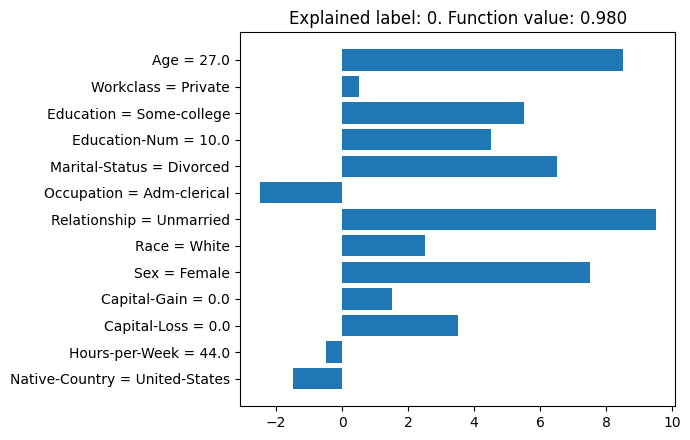

In [8]:
masker.render_result(instance, e, mode='plot', execute=True, col_names=col_names, category_mappings=mappings)

As we can see, when explaining class 0 (i.e., income less than or equal \\$50K), the biggest contributing (i.e., positive) factors are age (27), relationship (unmarried) and sex (female). By comparison, the administrative clerical occupation helps toward the more than $50K prediction, as does the United States as native country. In some cases, we may want the positive attribution values to indicate impact towards the "positive" label (i.e., more than \\$50K). We can use `label=1` in `explain_instance`, but a more convenient thing is to add `flip=True` to the rendering function call.

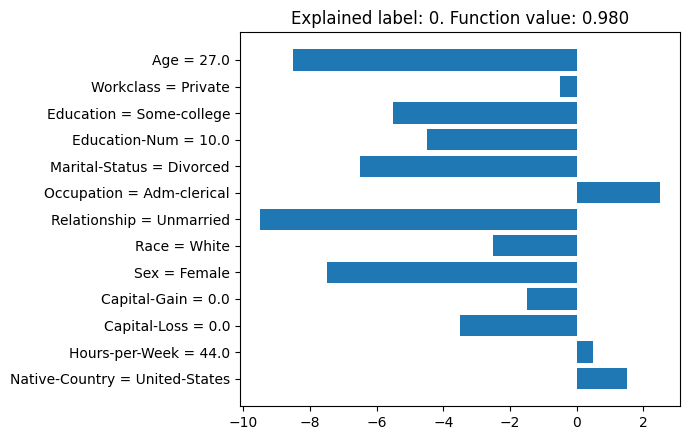

In [9]:
masker.render_result(instance, e, mode='plot', execute=False, flip=True, col_names=col_names, category_mappings=mappings)

And that's it! Want to learn more? Check out the other tabs for more use cases. If you want to gain a deeper understanding of the `*Masker` classes and implement your own, check out this jupyter notebook for an example where we build one from scratch and browse the documentations. Bugs? Suggestions? Questions? Ask away on [GitHub](https://github.com/YilunZhou/solvability-explainer)!